Files already downloaded and verified
Files already downloaded and verified


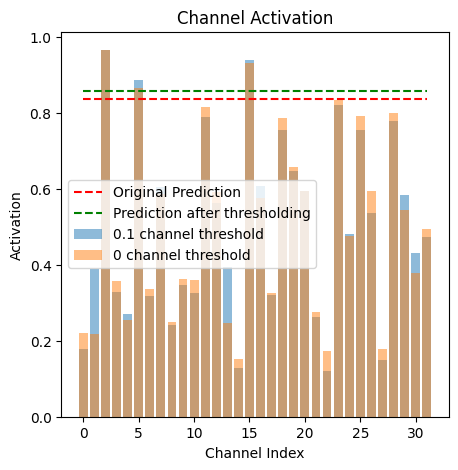

In [1]:
# load the image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
from Dataloaders import dataloader_cifar10
from Models import gatedmodel, mobilenetv2
from Utils import utils
import torch
import matplotlib.pyplot as plt

train, test, val, classes = dataloader_cifar10.Dataloader_cifar10_val()
client, server = mobilenetv2.mobilenetv2_splitter(weight_root='./Weights/cifar-10/', num_classes=10)

# get the client out 
client = client.cuda()
client.eval()
# freeze the grad 
for param in client.parameters():
    param.requires_grad = False

server = server.cuda()
server.eval()
# freeze the grad
for param in server.parameters():
    param.requires_grad = False

rate = [x/31 for x in range(32)]
accuracy = []

for ind, (img, label) in enumerate(val):
    img = img.cuda()
    label = label.cuda()
    break
    
out = client(img).detach()

# rank the output with zeros
c_rank = utils.ranker_zeros(out, 0.1, 0.5)
c_rank_non = utils.ranker_zeros(out, 0, 0.5)

c_act = np.zeros((128,32))
c_act_non = np.zeros((128,32))
for i in range(128):
    for j in range(32):
        c_act[i,c_rank[i,j]] = (31-j)/31
        c_act_non[i,c_rank_non[i,j]] = (31-j)/31
                                     

# plot the channel activation
plt.figure(figsize=(5,5))
# hist plot
c_act_mean = np.mean(c_act, axis=0)
c_act_non_mean = np.mean(c_act_non, axis=0)

plt.bar(range(32), c_act_mean, alpha=0.5, label='0.1 channel threshold')
plt.bar(range(32), c_act_non_mean, alpha=0.5, label='0 channel threshold')
plt.legend()
plt.xlabel('Channel Index')
plt.ylabel('Activation')
plt.title('Channel Activation')


# change the small value to zeros
out_cut = out.clone()
out_cut[torch.abs(out) < 0.1] = 0

pred = server(out).detach()
pred = torch.argmax(pred, dim=1)
pred_th = server(out_cut).detach()
pred_th = torch.argmax(pred_th, dim=1)

pred_acc = torch.sum(pred == label).item()/128
pred_th_acc = torch.sum(pred_th == label).item()/128

pred_x = [x for x in range(32)]
# plot a straigh line
plt.plot(pred_x, [pred_acc]*32, 'r--', label='Original Prediction')
plt.plot(pred_x, [pred_th_acc]*32, 'g--', label='Prediction after thresholding')
plt.legend()

# plot Q1: could we change some small value to zeros?
plt.show()

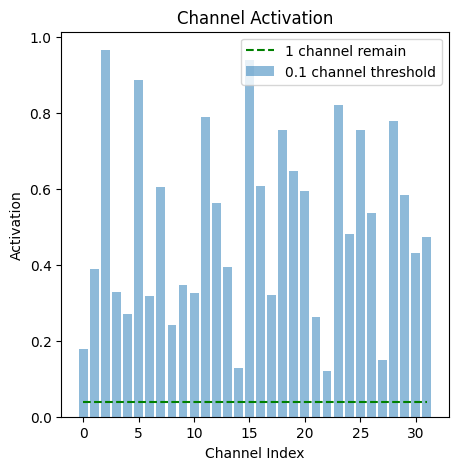

In [2]:
# second plot, use only one channel to see the effect
c_rank = utils.ranker_zeros(out_cut, 0.1, 0.5)
n_emb = torch.zeros_like(out_cut)
for i in range(128):
    n_emb[i,c_rank[i,0]] = out_cut[i,c_rank[i,0]]
   
pred_one = server(n_emb).detach()
pred_one = torch.argmax(pred_one, dim=1)

pred_one_acc = torch.sum(pred_one == label).item()/128

plt.figure(figsize=(5,5))
plt.bar(range(32), c_act_mean, alpha=0.5, label='0.1 channel threshold')
plt.xlabel('Channel Index')
plt.ylabel('Activation')
plt.title('Channel Activation')
plt.plot(pred_x, [pred_one_acc]*32, 'g--', label='1 channel remain')
plt.legend()
# plot Q2: using only one channel to see the effect?
plt.show()



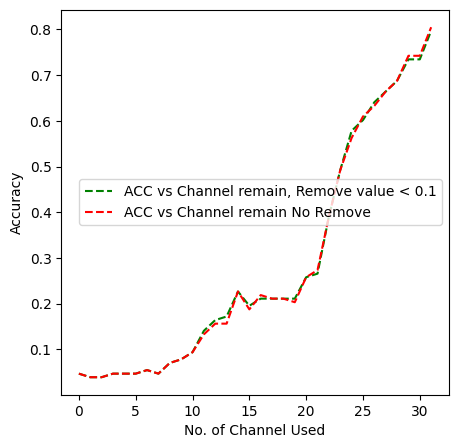

In [3]:
# second plot, use only one channel to see the effect
c_rank = utils.ranker_zeros(out_cut, 0.1, 0.5)
n_embs = [] #128,n,32,32 * 32
for j in range(32):
    n_emb = torch.zeros_like(out_cut)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank[i,k]] = out_cut[i,c_rank[i,k]]
    n_embs.append(n_emb)
pred_orders = []
for n_emb in n_embs:
    pred_order = server(n_emb)
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders.append(pred_order)
pred_order_accs = []
for pred_order in pred_orders:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs.append(pred_order_acc)

plt.figure(figsize=(5,5))
plt.plot(pred_x, pred_order_accs, 'g--', label='ACC vs Channel remain, Remove value < 0.1')
plt.xlabel('No. of Channel Used')
plt.ylabel('Accuracy')
plt.legend()


c_rank = utils.ranker_zeros(out, 0.1, 0.5)
n_embs = [] #128,n,32,32 * 32
for j in range(32):
    n_emb = torch.zeros_like(out)
    for i in range(128):
        for k in range (j):
            n_emb[i,c_rank[i,k]] = out[i,c_rank[i,k]]
    n_embs.append(n_emb)
pred_orders = []
for n_emb in n_embs:
    pred_order = server(n_emb)
    pred_order = torch.argmax(pred_order, dim=1)
    pred_orders.append(pred_order)
pred_order_accs = []
for pred_order in pred_orders:
    pred_order_acc = torch.sum(pred_order == label).item()/128
    pred_order_accs.append(pred_order_acc)

plt.plot(pred_x, pred_order_accs, 'r--', label='ACC vs Channel remain No Remove')
plt.legend()


# add the zerocount of each channel, examples





plt.show()
# plot Q3: using the number of number




torch.Size([128, 32])
torch.Size([10, 32, 16, 16])
torch.Size([1, 32])
torch.Size([1, 32, 16, 16])


/tmp/ipykernel_1176805/2164292478.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = matplotlib.cm.get_cmap('viridis', 10)


IndexError: index 2 is out of bounds for dimension 0 with size 1

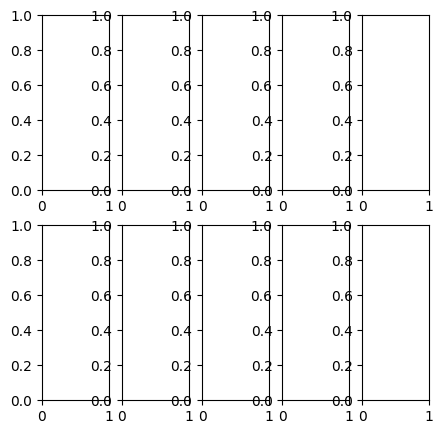

In [5]:
# change the zero rate cut off
import matplotlib
import tqdm

colors = matplotlib.cm.get_cmap('viridis', 10)
colors = colors(range(10))
# plot the zero distribution of 10 images
ax, fig = plt.subplots(2,5, figsize=(5,5))

embs = out_cut[:10].detach().cpu()
print(c_rank.size())
print(embs.size())
for i in range(10):
    emb = embs[i].unsqueeze(0)
    c_rank = utils.ranker_zeros(emb, 0.1, 0.5).cpu()
    print(c_rank.size())
    print(emb.size())
    for j in range(32):
        c = c_rank[j]
        emb_c = emb[c]
        fig[i//5, i%5].plot(emb_c, color=colors[j])
        fig[i//5, i%5].set_title('Label: {}'.format(label[i].item()))
    
